In [20]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [34]:
!pip install huggingface_hub
!pip install --upgrade huggingface_hub

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50
from transformers import AutoTokenizer, AutoModel
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import glob
import os
from torchvision.datasets import CocoCaptions
from pathlib import Path

In [22]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [44]:
from huggingface_hub import login
login()  # Follow prompts to enter your token

# Dataset

In [45]:
class CLIPDataset(Dataset):
    def __init__(self, image_text_pairs, transform=None):
        self.image_text_pairs = image_text_pairs  # List of (image, text) tuples
        self.transform = transform

    def __len__(self):
        return len(self.image_text_pairs)

    def __getitem__(self, idx):
        image, text = self.image_text_pairs[idx]

        # Ensure image is in RGB format
        if isinstance(image, str):  # If image is a path
            image = Image.open(image).convert("RGB")
        elif isinstance(image, Image.Image):
            image = image.convert("RGB")

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, text

In [74]:
# https://huggingface.co/datasets/nlphuji/flickr30k
def load_flickr30k_dataset(split="test", num_samples=None):
    # Load dataset from Hugging Face
    # Download and prepare the dataset (only needs to be done once)
    flickr_dataset = load_dataset("nlphuji/flickr30k", split=split)

    # Extract image-text pairs (using first caption per image for simplicity)
    image_text_pairs = []
    for i, item in enumerate(flickr_dataset):
        if num_samples and i >= num_samples:  # Limit size for faster testing
            break
        image = item["image"]  # PIL Image object
        caption = item["caption"][0]  # Use first caption (each image has 5)
        image_text_pairs.append((image, caption))

    return image_text_pairs

In [54]:
# Create transforms (same as your original)
clip_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

In [55]:
# Load Flickr30k dataset (e.g., 1000 samples for quick testing; remove num_samples for full dataset)
image_text_pairs = load_flickr30k_dataset(split="test", num_samples=1000) # Call the correct function to load the dataset
dataset = CLIPDataset(image_text_pairs, transform=clip_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

0000.parquet:  62%|######2   | 315M/506M [00:00<?, ?B/s]

0001.parquet:   0%|          | 0.00/502M [00:00<?, ?B/s]

0002.parquet:   0%|          | 0.00/506M [00:00<?, ?B/s]

0003.parquet:   0%|          | 0.00/512M [00:00<?, ?B/s]

0004.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

0005.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

0006.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

0007.parquet:   0%|          | 0.00/497M [00:00<?, ?B/s]

0008.parquet:   0%|          | 0.00/289M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/31014 [00:00<?, ? examples/s]

# Model

## Image Encoder

In [56]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()
        # Use ResNet50 as backbone (remove final classification layer)
        self.model = resnet50(pretrained=False)
        self.model.fc = nn.Identity()  # Remove final fully connected layer

        # Projection to joint embedding space
        self.projection = nn.Linear(2048, embed_dim)

    def forward(self, x):
        # Get image features
        features = self.model(x)

        # Project to joint embedding space
        embedding = self.projection(features)

        return embedding

## Text Encoder

In [57]:
class TextEncoder(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()
        # Use DistilBERT as text backbone
        self.tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
        self.model = AutoModel.from_pretrained("distilbert-base-uncased")

        # Projection to joint embedding space
        self.projection = nn.Linear(768, embed_dim)

    def forward(self, text):
        # Tokenize and get text features
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get last hidden states
        outputs = self.model(**inputs)
        last_hidden_state = outputs.last_hidden_state

        # Use [CLS] token representation as text embedding
        features = last_hidden_state[:, 0, :]

        # Project to joint embedding space
        embedding = self.projection(features)

        return embedding

## CLIP

In [58]:
class CLIP(nn.Module):
    def __init__(self, embed_dim=512, temperature=0.07):
        super().__init__()
        self.image_encoder = ImageEncoder(embed_dim)
        self.text_encoder = TextEncoder(embed_dim)
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / temperature))

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        # Initialize projection layers
        nn.init.normal_(self.image_encoder.projection.weight, std=0.02)
        nn.init.normal_(self.image_encoder.projection.bias, 0)
        nn.init.normal_(self.text_encoder.projection.weight, std=0.02)
        nn.init.normal_(self.text_encoder.projection.bias, 0)

    def encode_image(self, image):
        return self.image_encoder(image)

    def encode_text(self, text):
        return self.text_encoder(text)

    def forward(self, image, text):
        # Get image and text features
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)

        # Normalize features
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)

        # Cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        return logits_per_image, logits_per_text

# Contrastive Loss

In [60]:
def clip_loss(logits_per_image, logits_per_text):
    # Ground truth labels are the diagonal elements
    batch_size = logits_per_image.shape[0]
    labels = torch.arange(batch_size, device=device)

    # Cross entropy losses
    loss_i = F.cross_entropy(logits_per_image, labels)
    loss_t = F.cross_entropy(logits_per_text, labels)

    # Total loss
    loss = (loss_i + loss_t) / 2

    return loss

# Training

In [61]:
def train_clip(model, dataloader, optimizer, epochs=10):
    model.train()
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        for images, texts in progress_bar:
            images = images.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            logits_per_image, logits_per_text = model(images, texts)

            # Compute loss
            loss = clip_loss(logits_per_image, logits_per_text)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Update progress
            epoch_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

    return losses

In [62]:
# Initialize model and optimizer
clip_model = CLIP().to(device)
optimizer = optim.AdamW(clip_model.parameters(), lr=5e-5, weight_decay=0.2)

# Train the model
losses = train_clip(clip_model, dataloader, optimizer, epochs=10)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1/10: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s, loss=1.95]


Epoch 1 Average Loss: 3.3999


Epoch 2/10: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s, loss=1.66]


Epoch 2 Average Loss: 3.2584


Epoch 3/10: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s, loss=1.88]


Epoch 3 Average Loss: 3.0773


Epoch 4/10: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s, loss=1.68]


Epoch 4 Average Loss: 2.9074


Epoch 5/10: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s, loss=1.45]


Epoch 5 Average Loss: 2.7277


Epoch 6/10: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s, loss=1.29]


Epoch 6 Average Loss: 2.5822


Epoch 7/10: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s, loss=2.15]


Epoch 7 Average Loss: 2.4535


Epoch 8/10: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s, loss=1.99]


Epoch 8 Average Loss: 2.3577


Epoch 9/10: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s, loss=0.602]


Epoch 9 Average Loss: 2.1245


Epoch 10/10: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s, loss=2.05]

Epoch 10 Average Loss: 2.0289


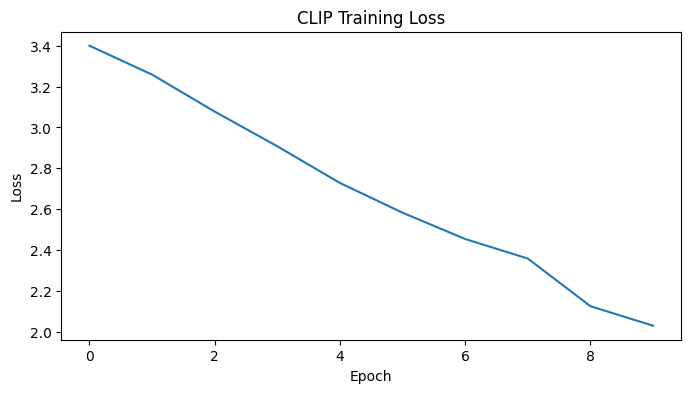

In [64]:
# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CLIP Training Loss")
plt.show()

## Downstream task 1: Classify

In [65]:
def zero_shot_classification(model, image, class_names, template="a photo of a {}"):
    model.eval()

    # Prepare text inputs
    text_inputs = [template.format(class_name) for class_name in class_names]

    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image.unsqueeze(0).to(device))
        text_features = model.encode_text(text_inputs).to(device)

        # Normalize features
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)

        # Calculate similarity
        logit_scale = model.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()

    # Get probabilities
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    return probs[0]

In [66]:
# Example zero-shot classification
class_names = ["cat", "dog", "bird", "car", "tree", "person", "building", "mountain"]
template = "a photo of a {}"

In [67]:
# Load a test image
test_image_url = "https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg"
response = requests.get(test_image_url)
test_image = Image.open(BytesIO(response.content)).convert("RGB")

# Preprocess image
test_image_tensor = clip_transform(test_image).to(device)

In [68]:
# Run zero-shot classification
probs = zero_shot_classification(clip_model, test_image_tensor, class_names, template)

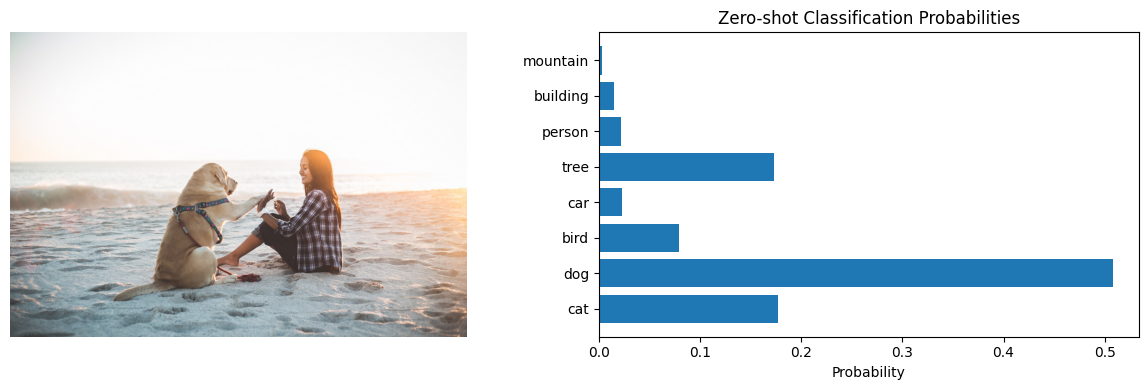

In [69]:
# Display results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.barh(class_names, probs)
plt.xlabel("Probability")
plt.title("Zero-shot Classification Probabilities")
plt.tight_layout()
plt.show()

# Downstream Task 2: Image Retrieval

In [79]:
def evaluate_retrieval(model, dataset, num_samples=4):
    model.eval()

    # Get sample images and their true captions from dataset
    sample_indices = range(num_samples)
    test_images = torch.stack([dataset[i][0] for i in sample_indices])
    test_texts = [dataset[i][1] for i in sample_indices]  # Get the actual paired text

    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(test_images.to(device))
        text_features = model.encode_text(test_texts).to(device)

        # Normalize features
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)

        # Calculate similarity
        logit_scale = model.logit_scale.exp()
        similarity_matrix = logit_scale * image_features @ text_features.t()

    # Display results
    plt.figure(figsize=(15, 10))

    # Show images with their correct captions and model predictions
    for i in sample_indices:
        # Get top matching text for this image
        values, indices = similarity_matrix[i].topk(1)
        matched_text = test_texts[indices[0]]

        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(test_images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)  # Unnormalize
        plt.title(f"Image {i+1}", fontsize=10)
        plt.axis("off")

        plt.subplot(num_samples, 2, 2*i+2)
        plt.text(0.1, 0.5,
                f"True Caption:\n{test_texts[i]}\n\n"
                f"Predicted Match:\n{matched_text}\n\n"
                f"Similarity: {values[0].item():.2f}",
                fontsize=10, va='center')
        plt.axis("off")

    plt.tight_layout()
    plt.show()

      # Print similarity matrix
    print("\nSimilarity Matrix (images x texts):")
    print(similarity_matrix.cpu().numpy())

    # Calculate recall metrics
    correct_matches = sum([i == similarity_matrix[i].argmax() for i in sample_indices])
    recall_at_1 = correct_matches / num_samples
    print(f"\nRecall@1: {recall_at_1:.2f} ({correct_matches}/{num_samples})")

    return similarity_matrix

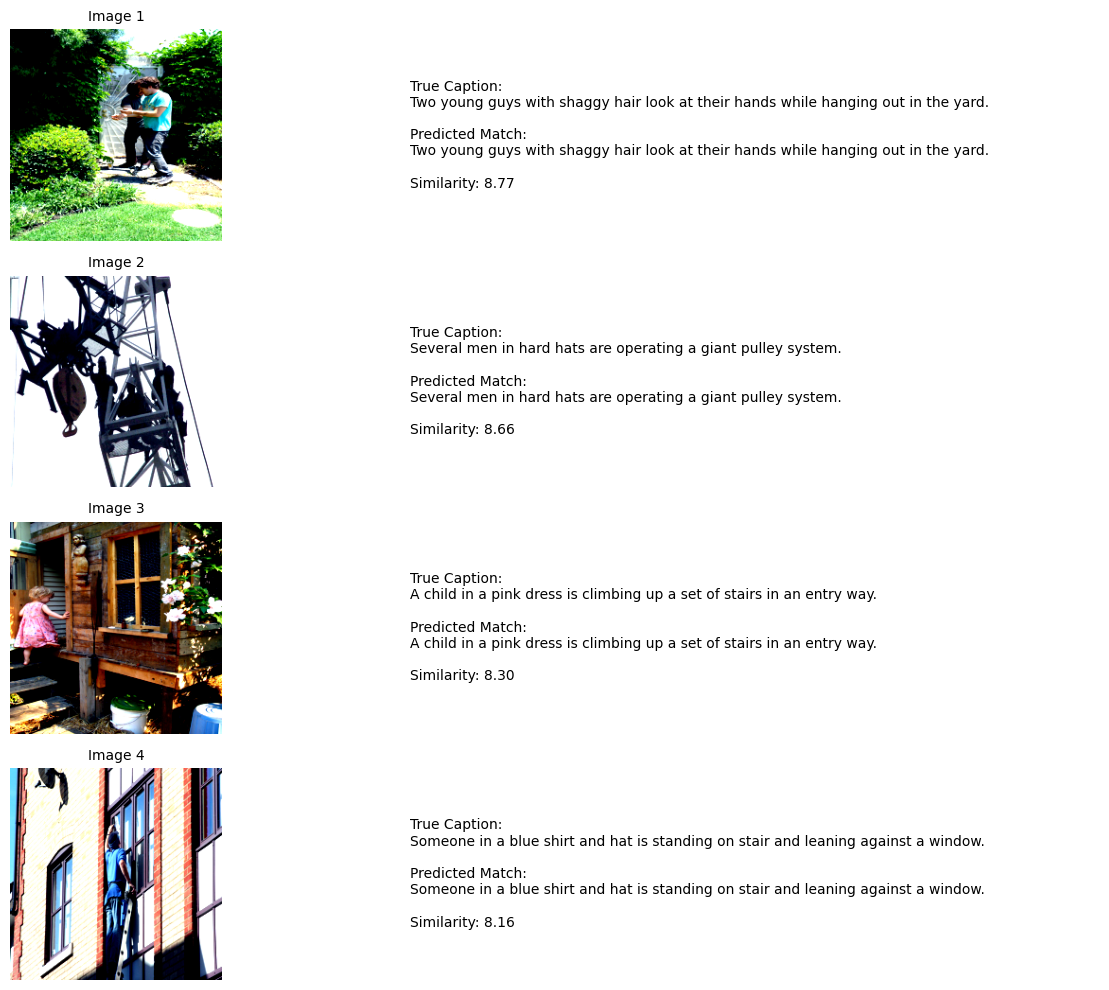

In [80]:
similarity_matrix = evaluate_retrieval(clip_model, dataset)

# Save and Load Model

In [ ]:
def save_model(model, path="clip_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def load_model(model, path="clip_model.pth"):
    model.load_state_dict(torch.load(path, map_location=device))
    print(f"Model loaded from {path}")
    return model

# Save model
save_model(clip_model)

# To load later:
# clip_model = CLIP().to(device)
# clip_model = load_model(clip_model)